

> Tambahkan blockquote



In [89]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Membuat model untuk sistem rekomendasi


# **Membuat desain model CNN untuk klasifikasi jenis - jenis tanah**

 kami mengambil dataset tanah dari [kagle](https://www.kaggle.com/datasets/fuadkahfi/dataset-tanah), kita mendapat 8 sampel jenis tanah dan total 880 datasets

untuk model arsitektur, kami meniru style [VGGNet CNN architecture](https://en.wikipedia.org/wiki/VGGNet). berikut model arsitektur yang kami buat:
> 320x320x3 --> 320x320x32 Conv1+ReLU --> max pooling --> 160x160x64 Conv2+ReLU --> max pooling --> 80x80x128 Conv3+ReLU --> max pooling --> Dropout(0.4) -> Flatten --> 1x1x128 fullyconnected1+ReLU --> Dropout(0.4) --> 1x1x8 fullyconnected2+softmax

dengan model tersebut, kami berhasil mendapatkan hasil yang luar biasa. hanya 4% gap antara training acc dan validation acc    
Epoch 100/100                                        
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9476 - loss: 0.1651 - val_accuracy: 0.9091 - val_loss: 0.3009

---


berikut model yang kami buat :

In [90]:
#@title Install required libraries

!pip install keras~=3.8.0 \
  matplotlib~=3.10.0 \
  numpy~=2.0.0 \
  pandas~=2.2.0

print('\n\nAll requirements successfully installed.')



All requirements successfully installed.


In [91]:
#@title Load dependencies

import io

# data
import numpy as numpy
import pandas as panda

# machine learning
import keras
import tensorflow as tf

# data visualization
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn

# dataset
import kagglehub
from google.colab import drive

In [106]:
# @title Mempersiapkan dataset
# drive.mount('/content/drive')
# !unzip /content/drive/MyDrive/dataset_tanah.zip -d /content/dataset
# dataset

import kagglehub

path = kagglehub.dataset_download("fuadkahfi/dataset-tanah")+"/Tanah"
print(path)


batch = 32 #@param
p = 320 #@param
l = 320 #@param

# data set yang akan di latih dan validasi
split = 0.2 # @param {"type":"number"}

raw_training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)

training_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="training",
    seed=1,

    image_size=(p, l),
    shuffle=True
)


# Load 80% train, 20% temp (val + test)
temp_dataset = tf.keras.utils.image_dataset_from_directory(
    path,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch,

    validation_split=split,
    subset="validation",
    seed=1,
    image_size=(p, l),
    shuffle=True
)

temp_dataset = temp_dataset.shuffle(buffer_size=1000, seed=1)

# Now split temp_dataset into val and test manually
validation_dataset = temp_dataset.take(int(0.5 * len(temp_dataset)))
test_dataset = temp_dataset.skip(int(0.5 * len(temp_dataset)))

# training_dataset = raw_training_dataset.prefetch(tf.data.AUTOTUNE)

# validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

class_names = raw_training_dataset.class_names
print("Class names:", class_names)
def count_dataset(dataset):
    total = 0
    for images, labels in dataset:
        total += images.shape[0]  # batch size may be smaller on last batch
    return total

print("Training samples:", count_dataset(training_dataset)/880*100)
print("Validation samples:", count_dataset(validation_dataset)/880*100)
print("Test samples:", count_dataset(test_dataset)/880*100)


Using Colab cache for faster access to the 'dataset-tanah' dataset.
/kaggle/input/dataset-tanah/Tanah
Found 880 files belonging to 8 classes.
Using 704 files for training.
Found 880 files belonging to 8 classes.
Using 704 files for training.
Found 880 files belonging to 8 classes.
Using 176 files for validation.
Class names: ['01-Aluvial', '02-Andosol', '03-Entisol', '04-Humus', '05-Inceptisol', '06-Laterit', '07-Kapur', '08-Pasir']
Training samples: 80.0
Validation samples: 9.090909090909092
Test samples: 9.090909090909092


In [93]:
#@title Membuat model

jenis = len(raw_training_dataset.class_names)
print(jenis)
droput = 0.4 #@param

augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(p, l, 3)),
    tf.keras.layers.Rescaling(1./255),
    augmentation,

#    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(droput),
    tf.keras.layers.Dense(jenis, activation='softmax')
])



8


In [95]:
#@title Tahap Melatih model dan validaasi model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,            # tolerates 7 bad epochs
    restore_best_weights=True
)

rate = 0.0005 # @param {"type":"number"}
epoch = 100 # @param {"type":"integer"}

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=rate),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epoch,
    callbacks=[early_stop]
)

# export model menjadi .tflite
model.save('model.keras')
convert = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model('model.keras'))
tflite_model = convert.convert()
with open("Tanah.tflite", "wb") as f:
    f.write(tflite_model)



Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.3676 - loss: 1.7589 - val_accuracy: 0.4688 - val_loss: 1.5897
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.3980 - loss: 1.5082 - val_accuracy: 0.9271 - val_loss: 1.1909
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.4692 - loss: 1.4173 - val_accuracy: 0.8646 - val_loss: 0.8914
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 248ms/step - accuracy: 0.5141 - loss: 1.3065 - val_accuracy: 0.9167 - val_loss: 0.7517
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.5250 - loss: 1.2227 - val_accuracy: 0.8750 - val_loss: 0.7237
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.5880 - loss: 1.1193 - val_accuracy: 0.9375 - val_loss: 0.6491
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.6324 - loss: 1.1085 - val_accuracy: 0.8333 - val_loss: 0.6093
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.6086 - loss: 1.0314 - val_acc

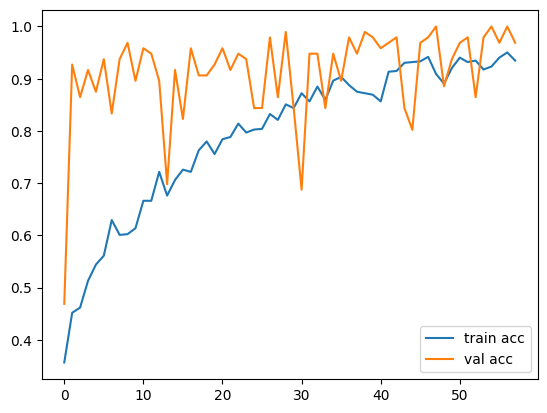

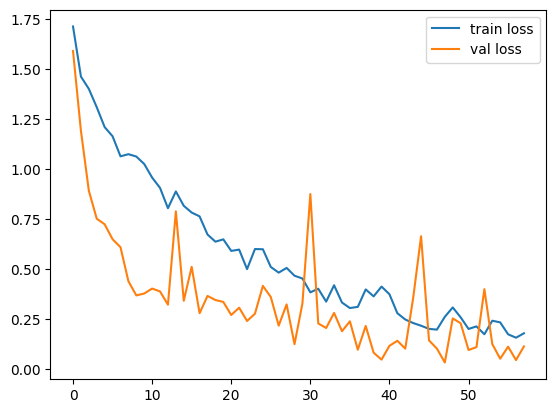

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
['01-Aluvial', '02-Andosol', '03-Entisol', '04-Humus', '05-Inceptisol', '06-Laterit', '07-Kapur', '08-Pasir']
               precision    recall  f1-score   support
01-Aluvial      0.909091  0.909091  0.909091  11.00000
02-Andosol      0.916667  0.916667  0.916667  12.00000
03-Entisol      1.000000  0.833333  0.909091  12.00000
04-Humus        0.857143  0.857143  0.857143   7.00000
05-Inceptisol   0.846154  0.916667  0.880000  12.00000
06-Laterit      1.000000  1.000000  1.000000  14.00000
07-Kapur        0.842105  1.000000  0.914286  16.00000
08-Pasir        0.900000  0.750000  0.818182  12.00000
accuracy        0.906250  0.906250  0.906250   0.90625
macro avg       0.908895  0.897863  0.900557  96.00000
weighted avg    0.910703  0.906250  0.905373  96.00000


In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# model.summary()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Step 1: Get all images and labels from your test dataset into numpy arrays
test_images_list = []
test_labels_list = []
for images_batch, labels_batch in test_dataset:
    test_images_list.append(images_batch.numpy())
    test_labels_list.append(labels_batch.numpy())

y_true = numpy.concatenate(test_labels_list, axis=0)
all_test_images = numpy.concatenate(test_images_list, axis=0)

# Step 2: Get model predictions using the collected numpy array of images
y_pred_probs = model.predict(all_test_images)
y_pred = numpy.argmax(y_pred_probs, axis=1)

# Step 3: Get the class names from the training dataset (or any dataset directly from the directory)
test_class_names = raw_training_dataset.class_names
print(test_class_names)

labels = list(range(len(test_class_names)))

report = classification_report(
    y_true, y_pred,
    labels=labels,
    target_names=test_class_names,
    output_dict=True,
    zero_division=0  # avoids divide-by-zero warnings
)

df = panda.DataFrame(report).transpose()
print(df)
df.to_csv("precision_table.csv", index=True)

# Image classification with TensorFlow Lite Model Maker with TensorFlow 2.18.0

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/tutorials/model_maker_image_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/tutorials/model_maker_image_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook has been moved [here](https://www.tensorflow.org/lite/tutorials/model_maker_image_classification).

In [ ]:

print(tf.__version__)

https://colab.research.google.com/github/TrainingBear/OPSI-Project-AndroidApplication/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb#scrollTo=w7AdazbUlvDJ